In [1]:
from metasyn import MetaFrame
import time
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from tqdm import tqdm
import datetime as dt
from faker import Faker
from metasyn.distribution import UniformDistribution
from metasyn.provider import BuiltinDistributionProvider
DEFAULT_NCOL = 30

In [2]:
def int_generator(size):
    for _ in range(DEFAULT_NCOL):
        yield pl.Series(np.random.randint(0, 1000, size=size))

In [3]:
def float_generator(size):
    for _ in range(DEFAULT_NCOL):
        yield pl.Series(np.random.rand(size))

In [4]:
def cat_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series(np.random.choice(["category1", "othercat", "whatinthename"], size=size), dtype=pl.Categorical)

In [5]:
def date_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series([dt.date(1954, 1, x) for x in np.random.randint(1, 32, size=size)])
    

In [6]:
def time_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series([dt.time(x, 12, 13) for x in np.random.randint(0, 24, size=size)])

In [7]:
def datetime_generator(size):
    for i in range(DEFAULT_NCOL):
        yield pl.Series([dt.datetime(x, 10, 14) for x in np.random.randint(1956, 2021, size=size)])

In [8]:
def string_generator(size):
    fake = Faker()
    # Faker.seed(12345)
    faker_types = ["address", "phone_number", "pricetag", "timezone", "mime_type", "unix_partition",
                   "ascii_email", "isbn10", "job", "ssn", "user_agent", "color", "license_plate",
                   "iban", "company", "time", "ipv4", "uri", "name", "sentence"]
    series_dict = {}
    
    for ftype in faker_types:
        series = pl.Series([getattr(fake, ftype)() for _ in range(size)])
        yield series
    yield pl.Series([fake.paragraph(nb_sentences=5) for _ in range(size)])

In [9]:
TYPE_GEN_DICT = {
    "discrete": int_generator,
    "continuous": float_generator,
    "categorical": cat_generator,
    "date": date_generator,
    "time": time_generator,
    "datetime": datetime_generator,
    "string": string_generator,
}

In [10]:
def benchmark_dist(distribution, df_generator, size):
    bench_times = []
    for series in df_generator(size):
        start_time = time.time()
        distribution.fit(series)
        bench_times.append(time.time()-start_time)
    return bench_times

In [11]:
def fit(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

In [12]:
x = 1e-5
print(f"{x:.3f}")

0.000


In [13]:
def benchmark(plot=False):
    provider = BuiltinDistributionProvider()
    for var_type in provider.all_var_types:
        if var_type == "string":
            max_size = 300
        else:
            max_size = 10000
        print(f"------------- {var_type} -------------")
        for dist in provider.get_dist_list(var_type):
            # Warm up FreeTextDistribution
            if issubclass(dist, FreeTextDistribution):
                for _ in range(3):
                    benchmark_dist(dist, "string", max_size)
            all_sizes = np.linspace(1, max_size, 20).astype(int)
            fit_times = []
            for size in all_sizes:
                fit_times.append(np.mean(benchmark_dist(dist, TYPE_GEN_DICT[var_type], size)))
            a_fit, b_fit = fit(all_sizes, fit_times)
            if plot:
                plt.plot(all_sizes, fit_times)
                plt.plot(all_sizes, a_fit*all_sizes+b_fit, label=f"{a_fit:.3e} * x + {b_fit:.3e}")
                plt.title(dist.implements)
                plt.xlabel("len(series)")
                plt.ylabel("t(s)")
                plt.legend()
                plt.show()
            print(dist.implements, a_fit, b_fit)

SyntaxError: expected ':' (1219890451.py, line 12)

------------- continuous -------------


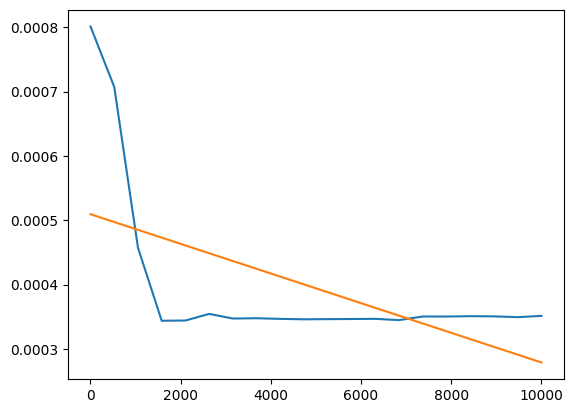

core.uniform -2.303554498338336e-08 0.000509406778788689


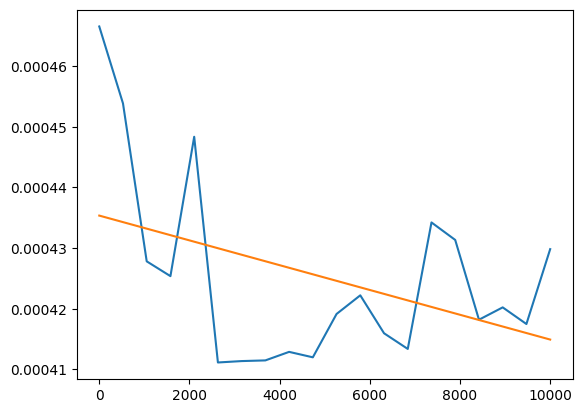

core.normal -2.044012551341574e-09 0.00043536261211106253


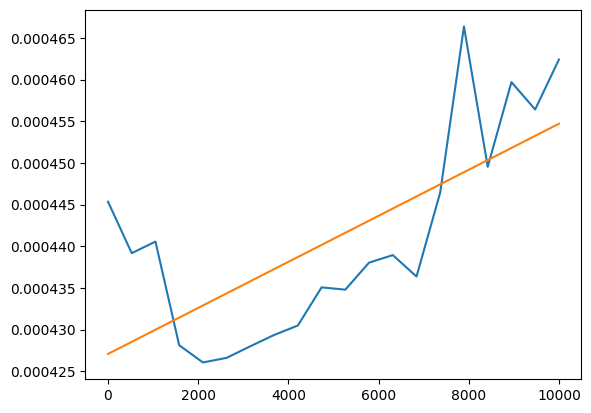

core.lognormal 2.761915016838525e-09 0.00042707670484475545


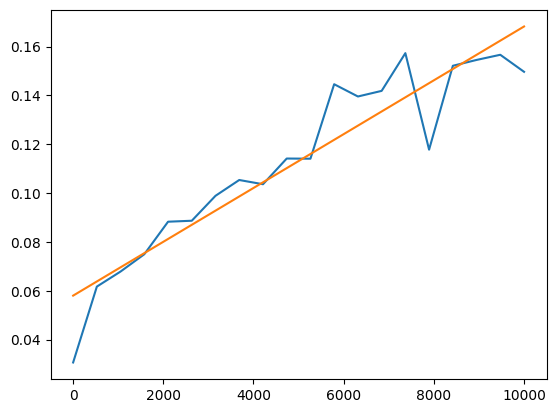

core.truncated_normal 1.1029833431429978e-05 0.057971531821657867


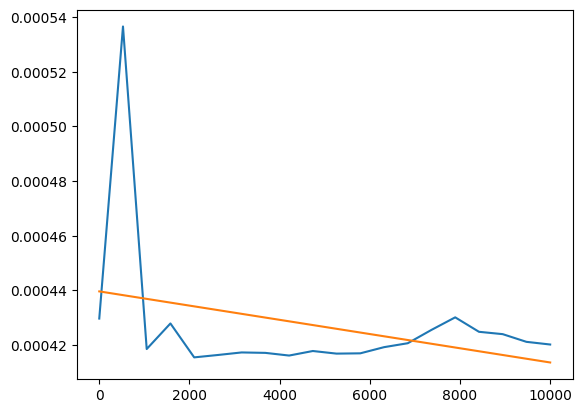

core.exponential -2.600122159747581e-09 0.0004396507881070919
------------- date -------------


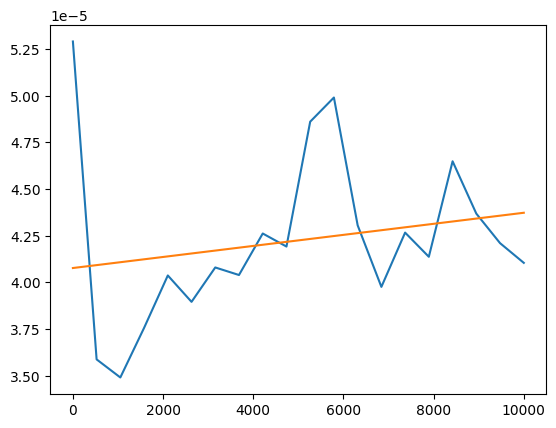

core.uniform_date 2.962338359898532e-10 4.0762614582170786e-05
------------- string -------------


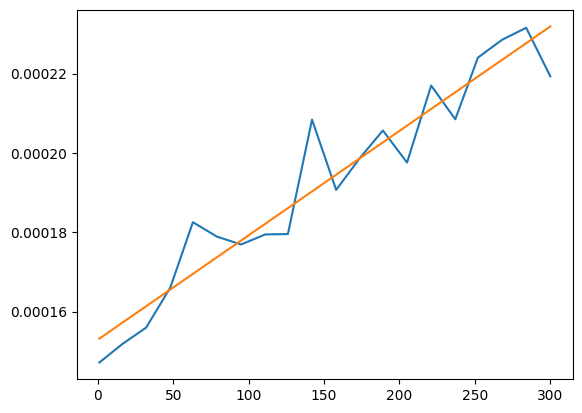

core.multinoulli 2.6322347604489424e-07 0.00015292697896934966


In [ ]:
benchmark(plot=True)

In [ ]:
from metasyn.distribution import FreeTextDistribution, RegexDistribution

def free_bench():
    free_times = []
    free_lengths = []
    for series in string_generator(100):
        start = time.time()
        # FreeTextDistribution.fit(series)
        RegexDistribution.fit(series)
        free_times.append(time.time()-start)
        free_lengths.append(series.str.lengths().mean())
    return np.array(free_lengths), np.array(free_times)


In [ ]:
def fit(x, y):
    A = np.vstack([x]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

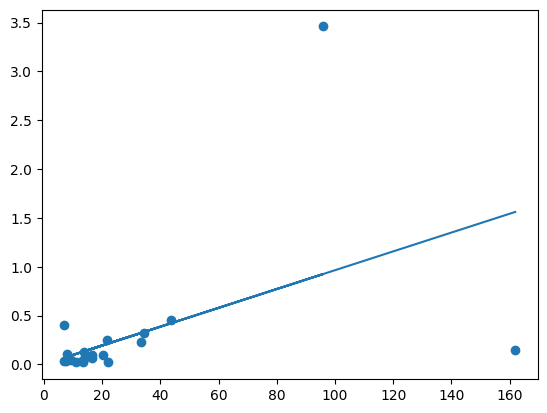

In [ ]:
lengths_first, times_first = free_bench()
# lengths_second, times_second = free_bench()
plt.scatter(lengths_first, times_first)
a= fit(lengths_first, times_first)
plt.plot(lengths_first, a*lengths_first)
plt.show()

In [ ]:
print(a)

[0.00964272]
